In [1]:
# Importing neccessary libraries

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from xgboost import XGBRegressor as xgbr
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
%matplotlib inline

# Data Cleaning

In [2]:
# Exported the database table created as csv and read as pandas dataframe

mobile_df = pd.read_csv('MobileData.csv')
mobile_df.head()

,brandName,os,osVersion,screenSizeInInches,displayType,resolutionInPixels,pixelDensity,rearCamera,frontCamera,batteryCapacity,fastCharging,cpuSpeed,processorCores,ramCapacity,gpuType,weight,internalStorage,externalStorage,yearOfRelease,price
0,OnePlus,Android,10,6.44,NaN,1080 x 2400,402,48 + 8 + 5 + 2,32,4115.0,Yes,"1x2.4 GHz, 1x2.2 GHz, 6x1.8 GHz",Octa-core,8 GB,Adreno 620,184,128 GB,NaN,2020,27999
1,OnePlus,Android,10,6.44,NaN,1080 x 2400,402,48 + 8 + 5 + 2,32,4115.0,Yes,"1x2.4 GHz, 1x2.2 GHz, 6x1.8 GHz",Octa-core,6 GB,Adreno 620,184,64GB,NaN,2020,24999
2,OnePlus,Android,10,6.44,NaN,1080 x 2400,402,48 + 8 + 5 + 2,32,4115.0,Yes,"1x2.4 GHz, 1x2.2 GHz, 6x1.8 GHz",Octa-core,12 GB,Adreno 620,184,256GB,NaN,2020,29999
3,Redmi,Android,10,6.67,NaN,1080 x 2400,395,48 + 8 + 5 + 2,16,5020.0,Yes,"2x2.3 GHz, 6x1.8 GHz",Octa-core,6 GB,Adreno 618,209,128 GB,NaN,2020,16999
4,Redmi,Android,10,6.67,NaN,1080 x 2400,395,48 + 8 + 5 + 2,16,5020.0,Yes,"2x2.3 GHz, 6x1.8 GHz",Octa-core,6 GB,Adreno 618,209,64 GB,NaN,2020,13999


In [3]:
# Getting the info of the data to chank for null values and datatypes

mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366 entries, 0 to 1365
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brandName           1366 non-null   object 
 1   os                  1353 non-null   object 
 2   osVersion           1338 non-null   object 
 3   screenSizeInInches  1364 non-null   object 
 4   displayType         1160 non-null   object 
 5   resolutionInPixels  1303 non-null   object 
 6   pixelDensity        1075 non-null   object 
 7   rearCamera          1357 non-null   object 
 8   frontCamera         1334 non-null   object 
 9   batteryCapacity     1361 non-null   float64
 10  fastCharging        692 non-null    object 
 11  cpuSpeed            1140 non-null   object 
 12  processorCores      1283 non-null   object 
 13  ramCapacity         1358 non-null   object 
 14  gpuType             985 non-null    object 
 15  weight              1112 non-null   object 
 16  intern

In [4]:
mobile_df.drop_duplicates(inplace=True)

In [5]:
# Filling all NaN values with np.nan

mobile_df = mobile_df.fillna(np.nan)

In [6]:
# Dropping all rows where brand name is not present 

mobile_df = mobile_df.loc[mobile_df.brandName!=0]

In [7]:
# Correct misspelled word and add in the same category level
# Keep the popular mobile phone brand in the category level and code all other levels as 'Others'

def get_binned_values(col_dict, colName, code_others):
    
    popular_values = [item for item in col_dict.keys()]

    for key, value in col_dict.items():
        mobile_df.loc[mobile_df[colName].str.lower().isin(value), colName] = key
    
    if code_others:
        mobile_df.loc[~mobile_df[colName].isin(popular_values), colName] = 'Others'

In [8]:
# Extract only the numerical values from a string

def get_numerical_value(colName, pattern):
    mobile_df[colName] = mobile_df[colName].apply(lambda x: float(re.findall(pattern, str(x))[0]) 
                                                  if len(re.findall(pattern, str(x))) != 0 else 0.0)

In [9]:
# As TB,GB,MB and KB is attatched to some values, removing GB from the values.
# Some value are in TB, MB and KB, converting to GB values.

def convert_to_gb(series):
    external_storage = []
    for val in series:
        converted_value = re.findall('\d+', str(val))
        if val == 0 or str(val).lower() == 'no' or len(converted_value)==0: 
            external_storage.append(0)
        elif 'TB' in str(val):
            external_storage.append(round(int(converted_value[0])*1000,2))
        elif 'MB' in str(val):
            external_storage.append(round(int(converted_value[0])*0.001,2))
        elif 'KB' in str(val):
            external_storage.append(round(int(converted_value[0])*0.000001,2))
        else:
            external_storage.append(int(re.findall('\d+', str(val))[0]))
    external_storage = pd.DataFrame({'storage_GB':external_storage})
    return external_storage

In [10]:
# add all the pixel values present in the rear and front camera

def add_pixels(colName):
    mobile_df[colName] = mobile_df[colName].apply(lambda x: re.findall('\d*[.]?\d+', str(x)))
    mobile_df[colName] = mobile_df[colName].apply(lambda x: round(sum([float(elem) for elem in x]),2) 
                                                        if len(x) > 0 else np.nan)

In [11]:
mobile_df.brandName.unique()

array(['OnePlus', 'Redmi', 'Samsung', 'Realme', 'POCO', 'Oneplus',
       'REALME', 'VIVO', 'Vivo', 'Oppo', 'Apple', 'Poco', 'Motorola',
       'Infinix', 'Xiaomi', 'Realme C2', 'iQOO', 'Asus', 'Nokia', 'Moto',
       'samsung', 'Tecno', 'Huawei', 'vivo', 'Itel', 'Jio', 'Micromax',
       'Honor', 'VIivo', 'Black Shark', 'Lenovo', 'ZTE', 'Google', 'iQoo',
       'LG', 'Coolpad', 'Hauwei', 'Nubia', 'Lava', 'Gionee', '10.or',
       'BlackBerry', 'Blackberry', 'Unihertz', 'Razer', 'Alcatel', 'vIVO',
       'HTC', 'IQOO', 'Techno', 'Meizu', 'Mobiistar', 'Xolo', 'Sharp',
       'Sony', 'Panasonic', 'Comio', 'InFocus', 'Cat', 'Tambo', 'Kult',
       'Intex', 'Detel', 'Homtom', 'iVoomi', 'Celkon', 'Blu', 'Trio',
       'Karbonn', 'Jivi', 'UR MOBILE', 'Centric', 'Ziox', 'Smartron',
       'Innelo', 'TP Link', 'Ulefone', 'Infocus', 'iVooMi', 'Swipe',
       'Gfive', 'Lenovo S5 Pro GT', 'Aqua'], dtype=object)

In [12]:
# Many brand values are duplicated because of captilization of letters. Binning those as one single brand.

# Considering only major market players and binning all other brands as 'Others'

brands_dict = {'OnePlus': ['oneplus'], 'Redmi': ['redmi'], 'Samsung': ['samsung'], 'Realme': ['realme', 'realme c2'], 
          'Poco': ['poco'], 'Nokia': ['nokia'], 'Vivo': ['vivo', 'viivo'], 'Oppo': ['oppo'], 'Apple': ['apple'],
          'Motorola': ['motorola', 'moto'], 'Xiaomi': ['xiaomi'], 'Asus': ['asus'], 'Huawei': ['huawei', 'hauwei'],
          'Honor': ['honor'], 'Google': ['google'], 'HTC': ['htc'], 'Lenovo':['lenovo', 'lenovo s5 pro gt']}

get_binned_values(col_dict=brands_dict, colName='brandName', code_others=True)

In [13]:
mobile_df.os.unique()

array(['Android', 'iOS', 'Android One', 'KAI', nan, 'Android Go',
       'Android Pie', 'Andoid'], dtype=object)

In [14]:
# Many OS names are misspelled.

# Android and iOS are considered as major OS options and all other os options are marked as others

os_dict = {'Android': ['android', 'android one', 'android go', 'android pie', 'andoid'], 'iOS': ['ios']}

get_binned_values(col_dict=os_dict, colName='os', code_others=True)

In [15]:
mobile_df.osVersion.unique()

array(['10', '9', '13', '8.1', '9.0', 'Android 9.0', nan, '8', '12',
       'v9.0', '7.1', '8.0', 'iOS', '8.1 Oreo Go', '7.0',
       'Oreo (Go edition)', '8.2', 'Android 9', '6.0', '6.0.1', 'v10 (Q)',
       '8.0 Oreo Go', '7', 'Android 9 Pie', '4.4'], dtype=object)

In [16]:
# extracting only the numerical value and removing any text attached to the value

get_numerical_value(colName='osVersion', pattern='^\d*[.]?\d')

In [17]:
mobile_df.screenSizeInInches.unique()

array(['6.44', '6.67', '6.5', '6.3', '6.39', '6.52', '6.4', '6.53',
       '6.50', '6.78', '6.65', '6.35', '6.40', '5.8', '6.7', '6.6',
       '6.22', '6.2', '5.45', '6.1', '6.38', '6.59', '6.01', '5', '6.18',
       '6.55', '6.51', '5.5', '6', '6.41', '2.45', '6.23', '6.0', '6.26',
       '6.14', '6.8', '6.57', '6.47', '5.99', '6.70', '5.26', '6.56',
       '5.84', '2.4', '5.6', '5.71', '4.7', '5.0', '4.5', '5.7', '6.21',
       '6.28', '6.81', '6.19', '5.9', '6.42', '6.95', '5.2', '6.66',
       '7.3', '5.93', '1.77', '6.15', '6.9', '5.86', '6.43', '5.65',
       '6.08', '7.8', '1.80', '6.20', '1.8', '6.09', '6.89', '5.34',
       '1.44', '4', nan, '4.95', '2/.8', '5.67', '5.3'], dtype=object)

In [18]:
# removing the row with invalid data

mobile_df = mobile_df[~(mobile_df.screenSizeInInches=='2/.8')]

In [19]:
mobile_df.displayType.unique()

array([nan, 'IPS', 'Super AMOLED', 'FHD Plus', 'OLED', 'Dynamic AMOLED',
       'Full HD', 'IPS LCD', 'HD Plus', 'HD+', 'HD', 'FHD+',
       'Fluid AMOLED', 'AMOLED', 'TFT', 'LTPS IPS LCD', 'FHD',
       'Optic AMOLED', 'QHD +', 'Super AMOLED capacitive',
       'Super AMOLED Capacitive with Multitouch',
       'IPS LCD capacitive touchscreen', 'LCD', 'QHFD',
       'AMOLED capacitive', 'Full HD LTPS IPS', 'QXGA+ Dynamic AMOLED',
       'P-OLED', 'Capacitive', 'Foldable Dynamic AMOLED',
       'TFT LCD display', 'IGZO IPS LCD', 'Super Amoled',
       'Full view display', 'ips', 'FWVGA+', 'QHD IPS', 'FWVGA',
       'Full HD Super AMOLED Capacitive touch', 'HD IPS', 'QHD', 'QVGA',
       'Super LCD', 'QQVGA',
       'Full HD Super AMOLED Capacitive Touchscreen',
       'HD+ Incell Full View', 'TFT LCD', 'HD Infinity Edge Display',
       'Capacitive Touchscreen', 'WVGA'], dtype=object)

In [20]:
display_type_series = []
for value in mobile_df.displayType:
    if type(value)==float:
        display_type_series.append(np.nan)
    elif 'AMOLED' in value.upper():
        display_type_series.append('AMOLED')
    elif 'OLED' in value.upper():
        display_type_series.append('OLED')
    elif 'QHD' in value.upper():
        display_type_series.append('QHD')
    elif ('FHD' in value.upper()) or ('FULL HD' in value.upper()):
        display_type_series.append('FHD')
    elif 'HD' in value.upper():
        display_type_series.append('HD')
    elif 'LCD' in value.upper():
        display_type_series.append('LCD')
    elif 'IPS' in value.upper():
        display_type_series.append('IPS')
    else:
        display_type_series.append('Others')
        
mobile_df['display_type'] = pd.Series(display_type_series, index=mobile_df.index)
mobile_df.drop(['displayType'], axis=1, inplace=True)

In [21]:
pixel_width = []
pixel_height = []
for val in mobile_df.resolutionInPixels:
    pixels = re.findall('\d*[.]?\d+', str(val))
    if len(pixels) > 1:
        pixel_width.append(pixels[0])
        pixel_height.append(pixels[1])
    else:
        pixel_width.append(np.nan)
        pixel_height.append(np.nan)
        
resolution_df = pd.DataFrame({'pixel_width':pixel_width, 'pixel_height':pixel_height}, index=mobile_df.index)

In [22]:
# Dropping 

mobile_df.drop(['resolutionInPixels'], axis=1, inplace=True)
mobile_df = mobile_df.join(resolution_df)

In [23]:
mobile_df.drop(['pixelDensity'], axis=1, inplace=True)

In [24]:
# adding all pixel values offered by each rear camera  

add_pixels(colName='rearCamera')

In [25]:
# adding all pixel values offered by each front camera 

add_pixels(colName='frontCamera')

In [26]:
mobile_df.fastCharging.unique()

array(['Yes', nan, 'USB', 'No', 'na'], dtype=object)

In [27]:
# Replacing no for all values other than Yes

fast_charging_dict = {'No': ['usb', 'no', 'na']}

get_binned_values(col_dict=fast_charging_dict, colName='fastCharging', code_others=False)

mobile_df.fastCharging = mobile_df.fastCharging.fillna('No')

In [28]:
# calculating entire cpu speed by combining all speed offered by each core of the cpu

cpu_speed = []
for item in mobile_df.cpuSpeed:
    temp = re.findall('\d*[x]\d*[.]?\d+|\d*[.]?\d+', str(item).lower())
    x = []
    for elem in temp:
        x1 = elem.split('x')
        x.append(float(x1[0])*float(x1[1]) if len(x1)>1 else float(x1[0]))
    if 'ghz' in str(item).lower():
        cpu_speed.append(round(sum(x),2))
    elif 'mhz' in str(item).lower():
        cpu_speed.append(round(sum(x)*0.001,2))
    else:
        cpu_speed.append(np.nan)
cpuSpeed = pd.DataFrame({'speed':cpu_speed})

mobile_df.cpuSpeed = cpuSpeed['speed'].values

In [29]:
mobile_df.processorCores.unique()

array(['Octa-core', 'octa', '1.8GHz octa', 'Octa', 'Hexa-core', nan,
       'OCTA', 'Quad', 'Hexa Core', 'octa-core', 'Dual', 'hexa',
       'Octa Core', 'Quad-core', 'quad',
       '1x2.84 GHz, 3x2.42 GHz,4x1.8 GHz', 'Octa core', 'quad-core'],
      dtype=object)

In [30]:
# Binning misspelled words in to single processor types

processor_cores_dict = {
    'Octa': ['octa-core', 'octa', '1.8ghz octa', 'octa-core', 'octa core', '1x2.84 ghz, 3x2.42 ghz,4x1.8 ghz'], 
    'Hexa': ['hexa-core', 'hexa', 'hexa core'],
    'Quad': ['quad', 'quad-core'],
    'Dual': ['dual']}

get_binned_values(col_dict=processor_cores_dict, colName='processorCores', code_others=False)

mobile_df.processorCores = mobile_df.processorCores.replace(to_replace='No', value=np.nan)

In [31]:
mobile_df.ramCapacity.unique()

array(['8 GB', '6 GB', '12 GB', '4 GB', '4GB', '3GB', '3 GB', '6GB',
       '2 GB', '2GB', '8GB', '12GB', '1GB', '512 MB', '8 MB', '1 GB',
       '10 GB', '4 MB', nan, '16 MB', '3 & 4 GB', '4 & 6 GB', '8',
       '1.5 GB', '32 MB', '4', '256 MB', '2 & 3 GB'], dtype=object)

In [32]:
#Getting only numeric values. Removing text like GB, MB attached to it and also converting all values in GB.

mobile_df.ramCapacity = convert_to_gb(series=mobile_df.ramCapacity).values

In [33]:
# Dropping gpu type as large number different gpu types 
# and also binning them don't make sense because each gpu is unique in ability

mobile_df.drop(['gpuType'], axis=1, inplace=True)

In [34]:
# Getting only numerical values. Removing text like 'g' attached to it

get_numerical_value(colName='weight', pattern='^\d*[.]?\d')

In [35]:
# Getting only numeric values. Removing text like GB, MB attached to it and also converting all values in GB.

mobile_df.internalStorage = convert_to_gb(series=mobile_df.internalStorage).values

In [36]:
# Getting only numeric values. Removing text like GB, MB attached to it and also converting all values in GB.

mobile_df.externalStorage = convert_to_gb(series=mobile_df.externalStorage).values

In [37]:
mobile_df.yearOfRelease = mobile_df.yearOfRelease.astype(object)

# Exploratory Data Analysis

In [38]:
# describing numerical features

mobile_df.describe()

,osVersion,rearCamera,frontCamera,batteryCapacity,cpuSpeed,ramCapacity,weight,internalStorage,externalStorage,price
count,835.000000,826.000000,808.000000,832.000000,660.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,8.241437,31.316707,14.091089,3729.084135,4.303439,4.495964,138.946707,85.606132,183.358084,21102.552096
std,2.087581,26.425221,8.953056,866.822114,5.928795,2.551626,155.683225,84.883630,224.025285,20897.514169
min,0.000000,0.300000,1.300000,650.000000,1.000000,0.000000,0.000000,0.000000,0.000000,399.000000
25%,8.000000,13.000000,8.000000,3060.000000,1.800000,3.000000,130.100000,32.000000,0.000000,8990.000000
50%,8.100000,18.000000,13.000000,4000.000000,2.000000,4.000000,168.000000,64.000000,128.000000,13999.000000
75%,9.000000,46.500000,18.000000,4066.250000,2.700000,6.000000,186.350000,128.000000,256.000000,23199.500000
max,13.000000,168.300000,61.000000,6050.000000,80.800000,12.000000,4030.000000,512.000000,2000.000000,164999.000000


In [39]:
mobile_df.describe(include=object)

,brandName,os,screenSizeInInches,fastCharging,processorCores,yearOfRelease,display_type,pixel_width,pixel_height
count,835,835,833,835,780,835,696,783,783
unique,18,3,80,2,4,3,8,29,59
top,Others,Android,6.3,No,Octa,2018,LCD,1080,2340
freq,225,803,58,479,619,372,281,379,150


In [40]:
mobile_df.shape

(835, 19)

In [41]:
# 0 value in this column represents missing values. replacing with nan values.

for col in ['osVersion', 'screenSizeInInches', 'batteryCapacity', 'ramCapacity', 'weight', 'internalStorage']:
    mobile_df[col] = mobile_df[col].apply(lambda x: np.nan if (x == 0 or x == 0.0) else x)

In [42]:
# calculating percentage of missing values

def missing_val_perc(df):
    for col in df.columns:
        print("Percentage of missing values in " + col + ": " + str(round(mobile_df[col].isna().sum()/mobile_df.shape[0],2)))

In [43]:
missing_val_perc(df=mobile_df)

Percentage of missing values in brandName: 0.0
Percentage of missing values in os: 0.0
Percentage of missing values in osVersion: 0.04
Percentage of missing values in screenSizeInInches: 0.0
Percentage of missing values in rearCamera: 0.01
Percentage of missing values in frontCamera: 0.03
Percentage of missing values in batteryCapacity: 0.0
Percentage of missing values in fastCharging: 0.0
Percentage of missing values in cpuSpeed: 0.21
Percentage of missing values in processorCores: 0.07
Percentage of missing values in ramCapacity: 0.01
Percentage of missing values in weight: 0.24
Percentage of missing values in internalStorage: 0.01
Percentage of missing values in externalStorage: 0.0
Percentage of missing values in yearOfRelease: 0.0
Percentage of missing values in price: 0.0
Percentage of missing values in display_type: 0.17
Percentage of missing values in pixel_width: 0.06
Percentage of missing values in pixel_height: 0.06


In [44]:
# Dropping rows having missing values more than 8

index_nums = [index for index, val in enumerate(mobile_df.isna().sum(axis=1)) if val>8]
mobile_df.drop(mobile_df.index[index_nums], inplace=True)

In [45]:
mobile_df.shape

(831, 19)

In [46]:
def cat_col_box_plot(colName, figSize):
    fig, ax = plt.subplots(figsize=figSize)
    fig = sns.boxplot(x=colName, y="price", data=mobile_df)
    fig.axis(ymin=0, ymax=200000)

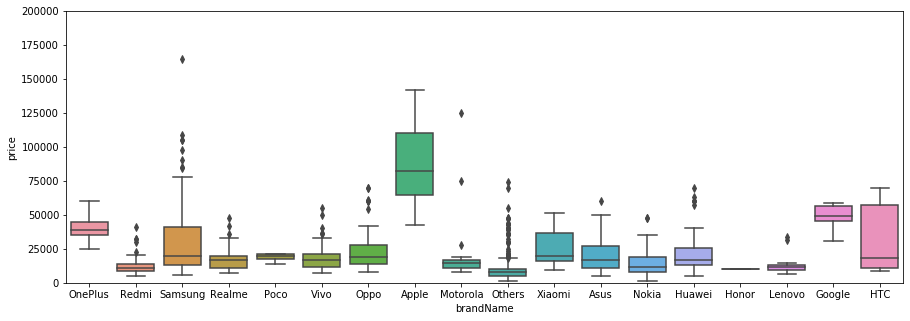

In [47]:
cat_col_box_plot(colName='brandName', figSize=(15,5))

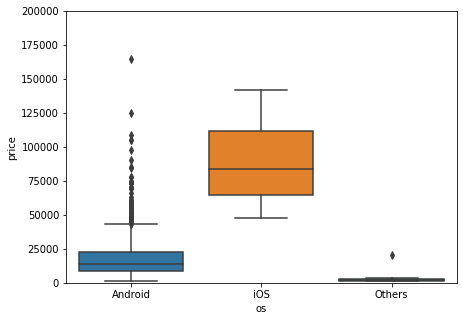

In [48]:
cat_col_box_plot(colName='os', figSize=(7,5))

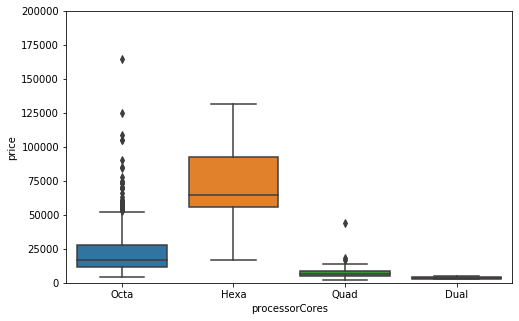

In [49]:
cat_col_box_plot('processorCores', (8,5))

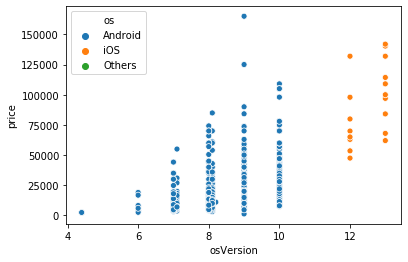

In [50]:
sns.scatterplot(mobile_df.osVersion, mobile_df.price, hue=mobile_df.os)

In [51]:
mobile_df.screenSizeInInches = mobile_df.screenSizeInInches.astype(float)

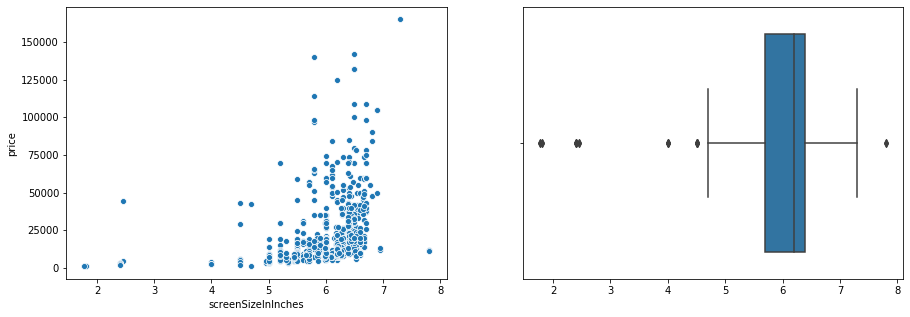

In [52]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(mobile_df.screenSizeInInches, mobile_df.price, ax=ax[0])
sns.boxplot([mobile_df.screenSizeInInches], ax=ax[1])

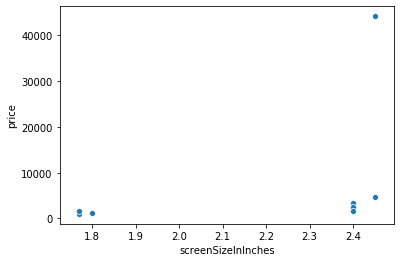

In [53]:
screensize_3 = mobile_df[mobile_df.screenSizeInInches<=3]
sns.scatterplot(screensize_3.screenSizeInInches, screensize_3.price)

In [54]:
mobile_df = mobile_df[~((mobile_df.screenSizeInInches<=3)&(mobile_df.price>10000))]

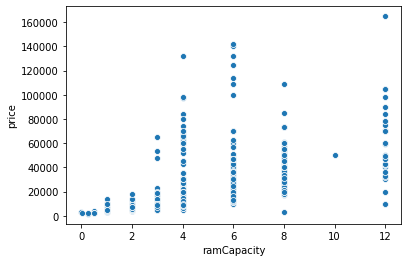

In [55]:
sns.scatterplot(x='ramCapacity', y="price", data=mobile_df)

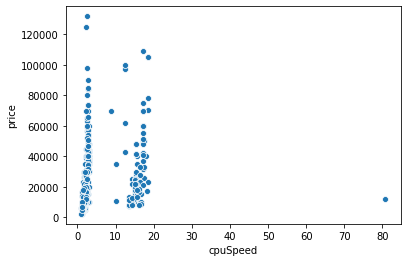

In [56]:
sns.scatterplot(mobile_df.cpuSpeed, mobile_df.price)

In [57]:
mobile_df = mobile_df[~(mobile_df.cpuSpeed>30)]

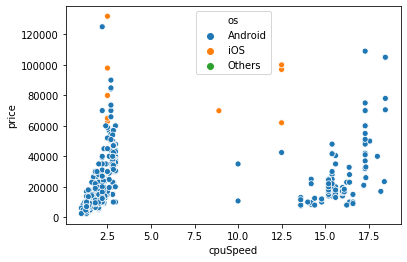

In [58]:
sns.scatterplot(mobile_df.cpuSpeed, mobile_df.price, hue=mobile_df.os)

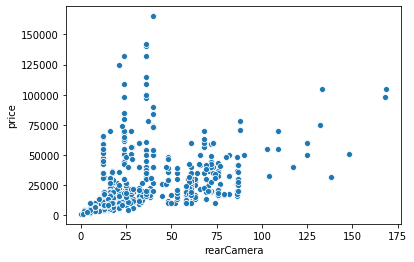

In [59]:
sns.scatterplot(mobile_df.rearCamera, mobile_df.price)

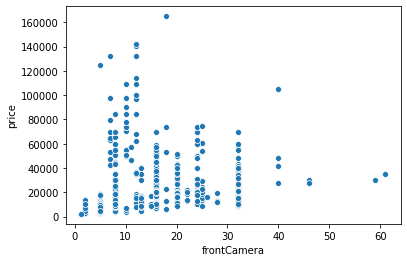

In [60]:
sns.scatterplot(mobile_df.frontCamera, mobile_df.price)

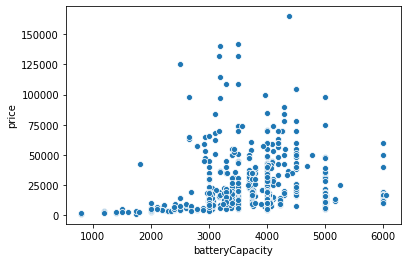

In [61]:
sns.scatterplot(mobile_df.batteryCapacity, mobile_df.price)

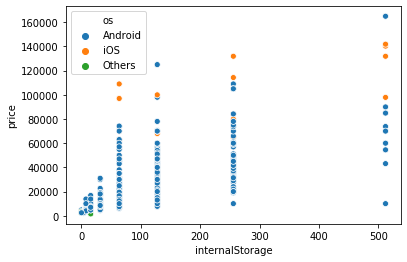

In [62]:
sns.scatterplot(mobile_df.internalStorage, mobile_df.price,hue=mobile_df.os)

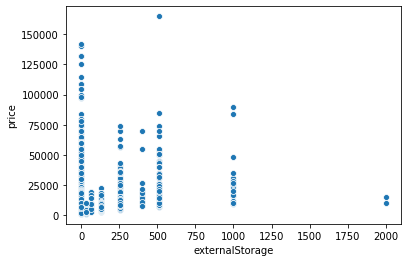

In [63]:
sns.scatterplot(mobile_df.externalStorage, mobile_df.price)

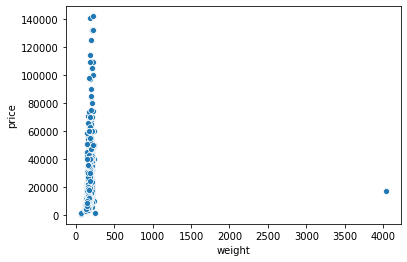

In [64]:
sns.scatterplot(mobile_df.weight, mobile_df.price)

In [65]:
mobile_df = mobile_df[~(mobile_df.weight>1000)]

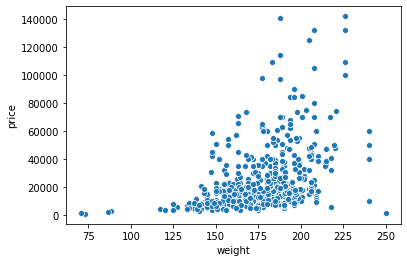

In [66]:
sns.scatterplot(mobile_df.weight, mobile_df.price)

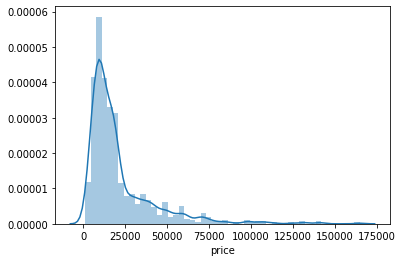

In [67]:
sns.distplot(mobile_df.price)

In [68]:
mobile_df_imputed = mobile_df.copy(deep=True)

In [69]:
osmask = mobile_df_imputed[(mobile_df_imputed.brandName=='Apple')&(mobile_df_imputed.os=='Android')].index
mobile_df_imputed.loc[osmask, 'os'] = 'iOS'

In [70]:
osversion_mask_1 = mobile_df_imputed[(mobile_df_imputed.osVersion.isna())&(mobile_df_imputed.price<=6000)].index
osversion_mask_2 = mobile_df_imputed[(mobile_df_imputed.osVersion.isna())&(mobile_df_imputed.os=='iOS')].index
osversion_mask_3 = mobile_df_imputed[(mobile_df_imputed.osVersion.isna())&(mobile_df_imputed.price>6000)].index
mobile_df_imputed.loc[osversion_mask_1, 'osVersion'] = mobile_df_imputed[mobile_df_imputed.price<=6000].osVersion.mode()[0]
mobile_df_imputed.loc[osversion_mask_2, 'osVersion'] = mobile_df_imputed[mobile_df_imputed.os=='iOS'].osVersion.mode()[0]
mobile_df_imputed.loc[osversion_mask_3, 'osVersion'] = mobile_df_imputed[mobile_df_imputed.price>6000].osVersion.mode()[0]

In [71]:
mobile_df_imputed.screenSizeInInches = mobile_df_imputed.screenSizeInInches.fillna(
                                                                            mobile_df_imputed.screenSizeInInches.mode()[0])

In [72]:
mobile_df_imputed.rearCamera = mobile_df_imputed.rearCamera.fillna(0)

In [73]:
front_cam_mask1 = mobile_df_imputed[(mobile_df_imputed.frontCamera.isna()) & (mobile_df_imputed.price<=5000)].index
front_cam_mask2 = mobile_df_imputed[(mobile_df_imputed.frontCamera.isna()) & 
                                    ((mobile_df_imputed.price>5000) & (mobile_df_imputed.price<=12000))].index
front_cam_mask3 =  mobile_df_imputed[(mobile_df_imputed.frontCamera.isna()) & (mobile_df_imputed.price>12000)].index
mobile_df_imputed.loc[front_cam_mask1, 'frontCamera'] = 0
mobile_df_imputed.loc[front_cam_mask2, 'frontCamera'] = mobile_df_imputed[(mobile_df_imputed.price>5000) & 
                                                                          (mobile_df_imputed.price<=20000)].frontCamera.mean()
mobile_df_imputed.loc[front_cam_mask3, 'frontCamera'] = mobile_df_imputed[mobile_df_imputed.price>20000].frontCamera.mean()

In [74]:
mobile_df_imputed.batteryCapacity = mobile_df_imputed.batteryCapacity.fillna(mobile_df_imputed.batteryCapacity.mean())

In [75]:
core_mask1 = mobile_df_imputed[(mobile_df_imputed.processorCores.isna()) & (mobile_df_imputed.price<=10000)].index
core_mask2 = mobile_df_imputed[(mobile_df_imputed.processorCores.isna()) & 
                                    ((mobile_df_imputed.price>10000) & (mobile_df_imputed.price<=50000))].index
core_mask3 =  mobile_df_imputed[(mobile_df_imputed.processorCores.isna()) & (mobile_df_imputed.price>50000)].index
mobile_df_imputed.loc[core_mask1, 'processorCores'] = mobile_df_imputed[mobile_df_imputed.price<=10000].processorCores.mode()[0]
mobile_df_imputed.loc[core_mask2, 'processorCores'] = mobile_df_imputed[(mobile_df_imputed.price>10000) & 
                                                                          (mobile_df_imputed.price<=50000)].processorCores.mode()[0]
mobile_df_imputed.loc[core_mask3, 'processorCores'] = mobile_df_imputed[mobile_df_imputed.price>50000].processorCores.mode()[0]

In [76]:
speed_mask1 = mobile_df_imputed[(mobile_df_imputed.cpuSpeed.isna()) & (mobile_df_imputed.processorCores=='Octa')].index
speed_mask2 = mobile_df_imputed[(mobile_df_imputed.cpuSpeed.isna()) & (mobile_df_imputed.processorCores=='Hexa')].index
speed_mask3 = mobile_df_imputed[(mobile_df_imputed.cpuSpeed.isna()) & (mobile_df_imputed.processorCores=='Quad')].index
speed_mask4 = mobile_df_imputed[(mobile_df_imputed.cpuSpeed.isna()) & (mobile_df_imputed.processorCores=='Dual')].index
mobile_df_imputed.loc[speed_mask1, 'cpuSpeed'] = mobile_df_imputed[mobile_df_imputed.processorCores=='Octa'].cpuSpeed.mean()
mobile_df_imputed.loc[speed_mask2, 'cpuSpeed'] = mobile_df_imputed[mobile_df_imputed.processorCores=='Hexa'].cpuSpeed.mean()
mobile_df_imputed.loc[speed_mask3, 'cpuSpeed'] = mobile_df_imputed[mobile_df_imputed.processorCores=='Quad'].cpuSpeed.mean()
mobile_df_imputed.loc[speed_mask4, 'cpuSpeed'] = mobile_df_imputed[mobile_df_imputed.processorCores=='Dual'].cpuSpeed.mean()

In [77]:
ram_mask1 = mobile_df_imputed[(mobile_df_imputed.ramCapacity.isna()) & (mobile_df_imputed.price<=6000)].index
ram_mask2 = mobile_df_imputed[(mobile_df_imputed.ramCapacity.isna()) & 
                                    ((mobile_df_imputed.price>10000) & (mobile_df_imputed.price<=20000))].index
mobile_df_imputed.loc[ram_mask1, 'ramCapacity'] = mobile_df_imputed[mobile_df_imputed.price<=6000].ramCapacity.mean()
mobile_df_imputed.loc[ram_mask2, 'ramCapacity'] = mobile_df_imputed[(mobile_df_imputed.price>10000) & 
                                                                    (mobile_df_imputed.price<=20000)].ramCapacity.mean()

In [78]:
weight_mask1 = mobile_df_imputed[(mobile_df_imputed.weight.isna()) & (mobile_df_imputed.price<=6000)].index
weight_mask2 = mobile_df_imputed[(mobile_df_imputed.weight.isna()) & 
                                    ((mobile_df_imputed.price>6000) & (mobile_df_imputed.price<=40000))].index
weight_mask3 =  mobile_df_imputed[(mobile_df_imputed.weight.isna()) & (mobile_df_imputed.price>40000)].index
mobile_df_imputed.loc[weight_mask1, 'weight'] = mobile_df_imputed[mobile_df_imputed.price<=6000].weight.mode()[1]
mobile_df_imputed.loc[weight_mask2, 'weight'] = mobile_df_imputed[(mobile_df_imputed.price>6000) & 
                                                                          (mobile_df_imputed.price<=40000)].weight.mode()[0]
mobile_df_imputed.loc[weight_mask3, 'weight'] = mobile_df_imputed[mobile_df_imputed.price>40000].weight.mode()[0]

In [79]:
mobile_df_imputed.internalStorage = mobile_df_imputed.internalStorage.fillna(0)

In [80]:
dispType_mask1 = mobile_df_imputed[(mobile_df_imputed.display_type.isna())&(mobile_df_imputed.price<=6000)].index
dispType_mask2 = mobile_df_imputed[(mobile_df_imputed.display_type.isna())&((mobile_df_imputed.price>6000)&
                                                                           (mobile_df_imputed.price<=20000))].index
dispType_mask3 = mobile_df_imputed[(mobile_df_imputed.display_type.isna())&(mobile_df_imputed.price>20000)].index
mobile_df_imputed.loc[dispType_mask1, 'display_type'] = mobile_df_imputed[mobile_df_imputed.price<=6000].display_type.mode()[0]
mobile_df_imputed.loc[dispType_mask2, 'display_type'] = mobile_df_imputed[(mobile_df_imputed.price>6000) & 
                                                                          (mobile_df_imputed.price<=20000)].display_type.mode()[0]
mobile_df_imputed.loc[dispType_mask3, 'display_type'] = mobile_df_imputed[mobile_df_imputed.price>20000].display_type.mode()[0]

In [81]:
pixel_wdh_mask1 = mobile_df_imputed[(mobile_df_imputed.pixel_width.isna()) & (mobile_df_imputed.price<=6000)].index
pixel_wdh_mask2 = mobile_df_imputed[(mobile_df_imputed.pixel_width.isna()) & 
                                    ((mobile_df_imputed.price>6000) & (mobile_df_imputed.price<=30000))].index
pixel_wdh_mask3 =  mobile_df_imputed[(mobile_df_imputed.pixel_width.isna()) & (mobile_df_imputed.price>30000)].index
mobile_df_imputed.loc[pixel_wdh_mask1, 'pixel_width'] = mobile_df_imputed[mobile_df_imputed.price<6000].pixel_width.mode()[0]
mobile_df_imputed.loc[pixel_wdh_mask2, 'pixel_width'] = mobile_df_imputed[(mobile_df_imputed.price>6000) & 
                                                                          (mobile_df_imputed.price<=30000)].pixel_width.mode()[0]
mobile_df_imputed.loc[pixel_wdh_mask3, 'pixel_width'] = mobile_df_imputed[mobile_df_imputed.price>30000].pixel_width.mode()[0]

In [82]:
pixel_hgt_mask1 = mobile_df_imputed[(mobile_df_imputed.pixel_height.isna()) & (mobile_df_imputed.price<=6000)].index
pixel_hgt_mask2 = mobile_df_imputed[(mobile_df_imputed.pixel_height.isna()) & 
                                    ((mobile_df_imputed.price>6000) & (mobile_df_imputed.price<=30000))].index
pixel_hgt_mask3 =  mobile_df_imputed[(mobile_df_imputed.pixel_height.isna()) & (mobile_df_imputed.price>30000)].index
mobile_df_imputed.loc[pixel_hgt_mask1, 'pixel_height'] = mobile_df_imputed[mobile_df_imputed.price<6000].pixel_height.mode()[0]
mobile_df_imputed.loc[pixel_hgt_mask2, 'pixel_height'] = mobile_df_imputed[(mobile_df_imputed.price>6000) & 
                                                                          (mobile_df_imputed.price<=30000)].pixel_height.mode()[0]
mobile_df_imputed.loc[pixel_hgt_mask3, 'pixel_height'] = mobile_df_imputed[mobile_df_imputed.price>30000].pixel_height.mode()[0]

In [83]:
brandName_cat = pd.Categorical(mobile_df_imputed.brandName, 
                                    categories = ['Samsung', 'Apple', 'Google', 'Huawei', 'OnePlus', 'Xiaomi',
                                                  'Redmi', 'Realme', 'Poco', 'Oppo', 'Vivo', 
                                                  'Asus', 'Nokia', 'Lenovo', 'HTC', 'Motorola', 
                                                  'Honor', 'Others'], ordered=True)
brandName_cat_labels, _ = pd.factorize(brandName_cat, sort=True)
mobile_df_imputed.brandName = brandName_cat_labels

In [84]:
display_type_cat = pd.Categorical(mobile_df_imputed.display_type, 
                                    categories = ['AMOLED', 'OLED', 'QHD', 'IPS', 'FHD', 'HD', 'LCD', 'Others'], ordered=True)
display_type_cat_labels, _ = pd.factorize(display_type_cat, sort=True)
mobile_df_imputed.display_type = display_type_cat_labels

In [85]:
label_encoder = LabelEncoder()

mobile_df_imputed['os'] = label_encoder.fit_transform(mobile_df_imputed['os'])

In [86]:
# binary encoding the fast charging 

mobile_df_imputed.fastCharging = mobile_df_imputed.fastCharging.map({'Yes':1, 'No':0})

In [87]:
# Ordinal encoding the processorCores

processor_core_cat = pd.Categorical(mobile_df_imputed.processorCores, 
                                    categories = ['Octa', 'Hexa', 'Quad', 'Dual'], ordered=True)
processor_core_labels, _ = pd.factorize(processor_core_cat, sort=True)
mobile_df_imputed.processorCores = processor_core_labels

In [88]:
for col in ['brandName', 'os', 'fastCharging', 'processorCores', 'display_type', 'yearOfRelease']:
    mobile_df_imputed[col] = mobile_df_imputed[col].astype('category')

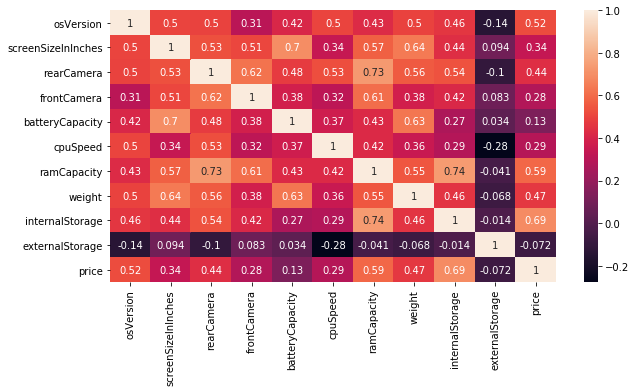

In [89]:
plt.figure(figsize=(10,5))
sns.heatmap(mobile_df_imputed.corr(), annot=True)

# Model Building

In [90]:
mobile_final_df = mobile_df_imputed.copy(deep=True)

In [91]:
mobile_final_df.head()

,brandName,os,osVersion,screenSizeInInches,rearCamera,frontCamera,batteryCapacity,fastCharging,cpuSpeed,processorCores,ramCapacity,weight,internalStorage,externalStorage,yearOfRelease,price,display_type,pixel_width,pixel_height
0,4,0,10.0,6.44,63.0,32.0,4115.0,1,15.4,0,8.0,184.0,128.0,0,2020,27999,0,1080,2400
1,4,0,10.0,6.44,63.0,32.0,4115.0,1,15.4,0,6.0,184.0,64.0,0,2020,24999,0,1080,2400
2,4,0,10.0,6.44,63.0,32.0,4115.0,1,15.4,0,12.0,184.0,256.0,0,2020,29999,0,1080,2400
3,6,0,10.0,6.67,63.0,16.0,5020.0,1,15.4,0,6.0,209.0,128.0,0,2020,16999,6,1080,2400
4,6,0,10.0,6.67,63.0,16.0,5020.0,1,15.4,0,6.0,209.0,64.0,0,2020,13999,6,1080,2400


In [92]:
mobile_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 1365
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   brandName           828 non-null    category
 1   os                  828 non-null    category
 2   osVersion           828 non-null    float64 
 3   screenSizeInInches  828 non-null    float64 
 4   rearCamera          828 non-null    float64 
 5   frontCamera         828 non-null    float64 
 6   batteryCapacity     828 non-null    float64 
 7   fastCharging        828 non-null    category
 8   cpuSpeed            828 non-null    float64 
 9   processorCores      828 non-null    category
 10  ramCapacity         828 non-null    float64 
 11  weight              828 non-null    float64 
 12  internalStorage     828 non-null    float64 
 13  externalStorage     828 non-null    int64   
 14  yearOfRelease       828 non-null    category
 15  price               828 non-null    int

In [93]:
for col in ['pixel_width', 'pixel_height']:
    mobile_final_df[col] = mobile_final_df[col].astype(int)

In [94]:
mobile_final_df.shape

(828, 19)

In [95]:
shuffled_df = mobile_final_df.sample(frac=1, random_state=204)

In [96]:
def get_rmse(y_act, y_pred):
    return  np.sqrt(mean_squared_error(y_act, y_pred))

rmse = make_scorer(get_rmse)

In [97]:
def get_scores(pred, test):
    print('Mean Absolute Error (MAE):', mean_absolute_error(pred, test))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(pred, test)))

**KNN Regressor**

In [117]:
knn_df = shuffled_df.copy(deep=True)

In [118]:
y_knn = np.log(shuffled_df.price)
X_knn = shuffled_df.drop(['price'], axis=1)

In [119]:
for col in X_knn.columns:
    if col not in ['brandName', 'os', 'fastCharging', 'processorCores', 'yearOfRelease']:
        X_knn.loc[:,col] = StandardScaler().fit_transform(np.array(X_knn.loc[:,col]).reshape(-1,1))

In [120]:
X_knn = pd.get_dummies(X_knn, drop_first=True)

Text(0, 0.5, 'Variance Explained')

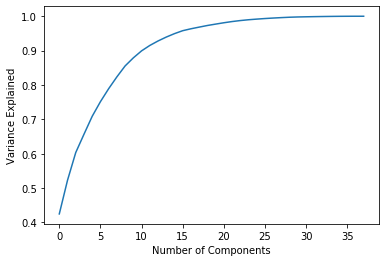

In [121]:
pca = PCA().fit(X_knn)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')

In [122]:
X_knn = pd.DataFrame(PCA(n_components=12).fit_transform(X_knn), columns=range(1,13,1))

In [123]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=204)

In [124]:
error_rate = []
for k in range(1,25,1):
    knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_model.fit(X_train_knn, y_train_knn)
    knn_predictions = knn_model.predict(X_test_knn)
    error_rate.append(np.sqrt(mean_squared_error(knn_predictions, y_test_knn)))

Text(0, 0.5, 'RMSE error rate')

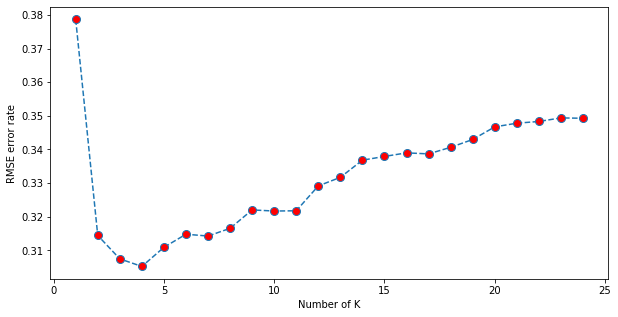

In [125]:
plt.figure(figsize=(10,5))
plt.plot(range(1,25,1), error_rate, linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.xlabel('Number of K')
plt.ylabel('RMSE error rate')

In [126]:
final_knn_model = KNeighborsRegressor(n_neighbors=4, weights='distance')
final_knn_model.fit(X_train_knn, y_train_knn)

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [127]:
final_knn_model.score(X_test_knn, y_test_knn)

0.859509508625425

In [128]:
knn_predictions = final_knn_model.predict(X_test_knn)

In [129]:
get_scores(pred=knn_predictions, test=y_test_knn)

Mean Absolute Error (MAE): 0.21890306213466845
Root Mean Squared Error (RMSE): 0.30524035288070794


**Support Vector Regression**

In [140]:
svr_model = SVR()

In [141]:
np.mean(cross_val_score(svr_model, X_train_knn, y_train_knn, scoring=rmse, cv=5, n_jobs=-1))

0.3500549341583958

In [142]:
best_svr_model = GridSearchCV(svr_model, param_grid={'C': [0.1,1,10,100,1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
                              scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [143]:
best_svr_model.fit(X_train_knn, y_train_knn)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [144]:
best_svr_model.best_params_

{'C': 10, 'gamma': 0.01}

In [145]:
np.mean(cross_val_score(best_svr_model.best_estimator_, X_train_knn, y_train_knn, scoring=rmse, cv=5, n_jobs=-1))

0.3466268132296033

In [146]:
final_svr_model = SVR(C=10, gamma=0.01)

In [147]:
final_svr_model.fit(X_train_knn, y_train_knn)

SVR(C=10, gamma=0.01)

In [148]:
final_svr_model.score(X_test_knn, y_test_knn)

0.8419550931892148

In [149]:
svr_predictions = final_svr_model.predict(X_test_knn)

In [150]:
get_scores(pred=svr_predictions, test=y_test_knn)

Mean Absolute Error (MAE): 0.2308565430544729
Root Mean Squared Error (RMSE): 0.3237492221102369


**Random Forest Regression**

In [98]:
rf_df = shuffled_df.copy(deep=True)

In [99]:
y_rf = np.log(shuffled_df.price)
X_rf = shuffled_df.drop(['price'], axis=1)

In [100]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=204)

In [103]:
for estimator in range(200, 1050, 50):
    random_forest = RandomForestRegressor(n_estimators= estimator, random_state=204)
    print("No of estimators " + str(estimator) + ": " + 
        str(round(np.mean(-cross_val_score(random_forest, X=X_train_rf, y=y_train_rf, cv=5, 
                                          scoring='neg_mean_squared_error', n_jobs=-1)),4)))

No of estimators 200: 0.0933
No of estimators 250: 0.0939
No of estimators 300: 0.0938
No of estimators 350: 0.0937
No of estimators 400: 0.0936
No of estimators 450: 0.0938
No of estimators 500: 0.0937
No of estimators 550: 0.0935
No of estimators 600: 0.0934
No of estimators 650: 0.0933
No of estimators 700: 0.0934
No of estimators 750: 0.0935
No of estimators 800: 0.0934
No of estimators 850: 0.0935
No of estimators 900: 0.0934
No of estimators 950: 0.0934
No of estimators 1000: 0.0934


In [104]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=204, oob_score=True)
best_rf_model = GridSearchCV(rf_model, param_grid={'max_depth':[2,3,6,8,10], 'min_samples_split':[2,4,8,35], 
                                                   'max_features':[None,'sqrt','log2'], 'min_samples_leaf':[1,2,4,6]}, 
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [105]:
best_rf_model.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, oob_score=True,
                                             random_state=204),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 6, 8, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 4, 8, 35]},
             scoring='neg_mean_squared_error')

In [106]:
best_rf_model.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [107]:
np.mean(cross_val_score(best_rf_model.best_estimator_, X_train_rf, y_train_rf, scoring=rmse, cv=5, n_jobs=-1))

0.28628210430254464

In [108]:
final_rf_model = RandomForestRegressor(n_estimators=250, max_depth=10, max_features='sqrt', oob_score=True, n_jobs=-1)

In [109]:
final_rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=250,
                      n_jobs=-1, oob_score=True)

In [110]:
final_rf_model.score(X_test_rf, y_test_rf)

0.8747533902659578

In [111]:
rf_predictions = final_rf_model.predict(X_test_rf)

In [112]:
get_scores(pred=rf_predictions, test=y_test_rf)

Mean Absolute Error (MAE): 0.2025602340711286
Root Mean Squared Error (RMSE): 0.2882049732272642


**Xtreme Gradient Boosting Machine**

In [113]:
xgbm_df = mobile_df_imputed.copy(deep=True)

In [114]:
for col in ['brandName', 'os', 'fastCharging', 'processorCores', 'display_type', 'yearOfRelease']:
    xgbm_df[col] = xgbm_df[col].astype('category')

In [115]:
for col in ['pixel_width', 'pixel_height']:
    xgbm_df[col] = xgbm_df[col].astype(int)

In [116]:
xgbm_df_dummified = pd.get_dummies(data=xgbm_df, columns=['brandName', 'os', 'fastCharging', 'processorCores', 
                                                          'display_type', 'yearOfRelease'])

In [117]:
shuffled_df_1 = xgbm_df_dummified.sample(frac=1)

In [118]:
y_xgb = np.log(shuffled_df_1.price)
X_xgb = shuffled_df_1.drop(['price'], axis=1)

In [119]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=1234)

In [120]:
xgbm = xgbr()
best_xgbm = GridSearchCV(xgbm, param_grid={'n_estimators':[500,750,1200,2000], 'learning_rate':[0.001,0.01, 0.03, 0.06, 0.1]}, 
                        n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

In [121]:
best_xgbm.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [122]:
best_xgbm.best_params_

{'learning_rate': 0.06, 'n_estimators': 500}

In [123]:
np.mean(cross_val_score(best_xgbm.best_estimator_, X_train_xgb, y_train_xgb, scoring=rmse, cv=5, n_jobs=-1))

0.30172500777575983

In [124]:
xgbm = xgbr(n_estimators=500, learning_rate=0.06)
best_xgbm = GridSearchCV(xgbm, param_grid={'min_child_weight':[1,0.01,0.1,5],'max_depth':[2,3,4,6,10], 'gamma':[0.001, 0.01, 0.1, 5, 10]}, 
                        n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

In [125]:
best_xgbm.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.06, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=500, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [126]:
best_xgbm.best_params_

{'gamma': 0.01, 'max_depth': 6, 'min_child_weight': 1}

In [127]:
np.mean(cross_val_score(best_xgbm.best_estimator_, X_train_xgb, y_train_xgb, scoring=rmse, cv=5, n_jobs=-1))

0.2989133462070577

In [154]:
gbm_model_1 = xgbr(n_estimators=500, learning_rate=0.06, gamma=0.1, max_depth=6, min_child_weight=5, random_state=402,
                  colsample_bytree=0.4, colsample_bylevel=0.4, reg_lambda=0.001)

In [156]:
np.mean(cross_val_score(gbm_model_1, X_train_xgb, y_train_xgb, scoring=rmse, cv=5, n_jobs=-1))

0.2887414492661285

In [157]:
final_xgbm = xgbr(n_estimators=500, learning_rate=0.06, gamma=0.1, max_depth=6, min_child_weight=5, random_state=402,
                  colsample_bytree=0.4, colsample_bylevel=0.4, reg_lambda=0.001)

In [158]:
final_xgbm.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.06, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=402,
             reg_alpha=0, reg_lambda=0.001, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
final_xgbm.score(X_test_xgb, y_test_xgb)

0.8902017994767528

In [160]:
xgbm_predictions = final_xgbm.predict(X_test_xgb)

In [161]:
get_scores(pred=xgbm_predictions, test=y_test_xgb)

Mean Absolute Error (MAE): 0.19801235595182515
Root Mean Squared Error (RMSE): 0.27863242407967653
